# Guided Project: Finding Heavy Traffic Indicators on I-94

We're analyzing [traffic data](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) on I-94 from Minneapolis to Saint Paul, USA (the station only records westbound traffic; cars moving from east to west). Our goal is to find the indicators of heavy traffic on I-94 and visualize it through relational plots.

In [1]:
import pandas as pd

# Open the file:
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

# Check if we're opening the right data:
print(traffic.head(), '\n')
print(traffic.tail(), '\n')

traffic.info()

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918   

      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0 

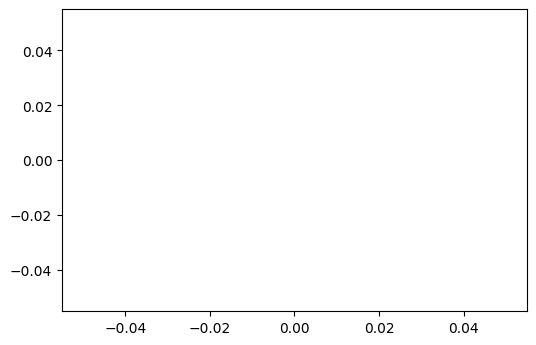

In [2]:
# (1) Import matplotlib module and 
# (2) allow Jupyter to generate the graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Check check 1, 2, 3
plt.plot()
plt.show()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64


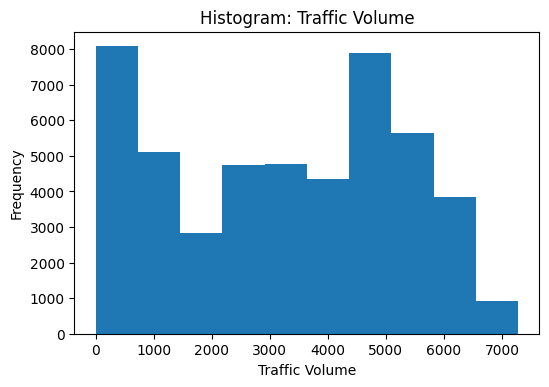

In [3]:
# ^ All good.

# Look up few statistic on the column `traffic_volume`
print(traffic['traffic_volume'].describe())

# Make a histogram out of the column.
plt.hist(traffic['traffic_volume'])
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Histogram: Traffic Volume')
plt.show()

On the histogram above, we can see that most frequency of traffic are in 1st (0-728) and 7th (4368-5096) percentile, followed by the 8th percentile This implies that there are a good amount of times where the traffic's heavy.

*"Do you think daytime and nighttime influence the traffic volume?"*
I think daytime and nighttime makes a good difference in the volume. People may go home from work or travel to St. Paul. That's my thought, but let's  analyze the data, shall we?

If we're including the statistics on `traffic['traffic_volume'].describe()`, we can see on the quartile data that:
1. 25% of the time there were 1,193 cars or fewer passing the station, and
2. 75% of the time there were 4,933 cars of fewer.
    * The rest 4th quartile has >4,933 cars.
* Through the volume difference, we can speculate that the (1) might happen at nighttime and (2) might happen at daytime. Let's dig deeper!

In [7]:
# Convert data in column `date_time` to type(datetime)
# * v Don't forget to assign it to the current column:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

# ^H = With some help.
# Do it by copying the DataFrame with inserted Boolean args.

# Segment the days, .. ^H
day   = traffic.copy()[(traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19) ]
print(day.shape)

# and the nights. ^H
night = traffic.copy()[(traffic['date_time'].dt.hour >= 19) | (traffic['date_time'].dt.hour < 7) ]
print(night.shape)

(23877, 9)
(24327, 9)


Next up: After we're separating the `DataFrame` of daytime and nighttime traffic volume, we can make two plots at once for an easier comparison. We also want to bring up `Series.describe()` to look on each quartile for traffic distribution. 

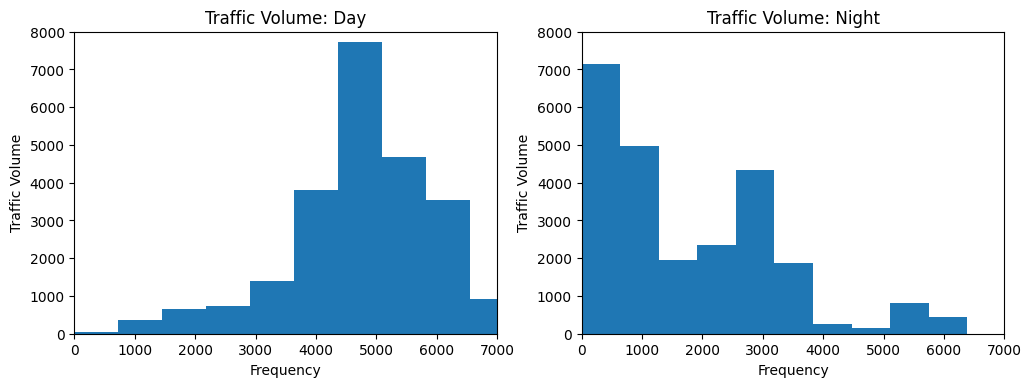

In [20]:
# If you want to compare, use figure + subplot.

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.title('Traffic Volume: Day')
plt.xlabel('Frequency')
plt.ylabel('Traffic Volume')
plt.xlim([0,7000])
plt.ylim([0,8000])

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.title('Traffic Volume: Night')
plt.xlabel('Frequency')
plt.ylabel('Traffic Volume')
plt.xlim([0,7000])
plt.ylim([0,8000])

plt.show()

In [18]:
# Look up statistics at traffic on both times
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [19]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

**Analysis:** 
* The histograms show two different shapes: left-skewed for `day` and right-skewed for `night`. The statistics also shows that 1st-3rd quartile of `day` is larger than `night`. This shows that the traffic's heavier on the `day`.
* "So, should we still use the night-time data to determine the indicators?" 
    * ❌ Looking at the data, the only variable included are the temperature and weather: `rain`, `snow`, `clouds`. So I think it's still necessary to include them in.`
    * ✅ Since we're analyzing indicators of **heavy traffic** and night time is light in traffic, we don't include the `night` data. :D

# Indicators

## (1) Time

Now the traffic data gets cleaned, we can look at the indicators. Let's dive in to time first. We can group the traffic volume with a variable by using a built-in method `DataFrame.groupby()`. Since we have the data of time and weather which varies throughout months, we will group the `traffic_volume` by `month`.

In [21]:
day['month'] = day['date_time'].dt.month
by_month     = day.groupby('month').mean()
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

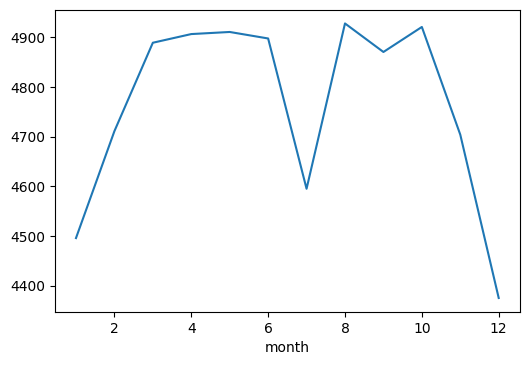

In [23]:
by_month['traffic_volume'].plot.line()
plt.title('Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Average Traffic Volume')
plt.show()

We can also group the data by day of the week with `Series.dt.dayofweek()`

In [24]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume'] # 0 is Monday, 6 is Sunday

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

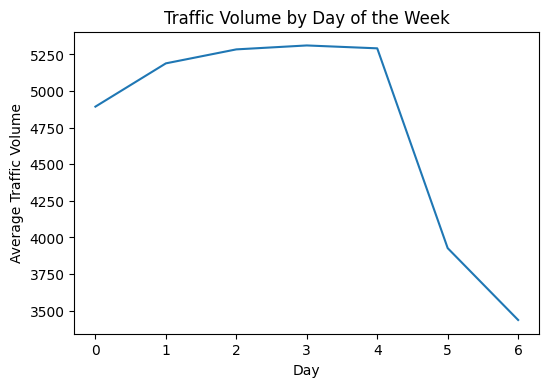

In [29]:
by_dayofweek['traffic_volume'].plot.line()
plt.title('Traffic Volume by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Traffic Volume')
plt.show()

**Analysis:** From both charts, we can see that:
* The lines peak on month 2-6 and 8-10. 
* The traffic volume is bigger on weekdays (0-4: Mon-Fri) than weekends (5-6: Sat-Sun)

We can slice into both weekdays and weekends even further by grouping it into hours:

In [30]:
day['hour'] = day['date_time'].dt.hour
# We've assigned `day['dayofweek'] beforehand ☝️
business_days = day.copy()[day['dayofweek'] <= 4] # 0-4 == Mon-Fri
weekend = day.copy()[day['dayofweek'] >= 5] # 5-6 = Sat-Sun
by_hour_business = business_days.groupby('hour').mean()
by_hour_weekend  = weekend.groupby('hour').mean()

# One thing you realize:
## If something went error, check the data-type.
## At times you mistook the type Series as DataFrame in a method.

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


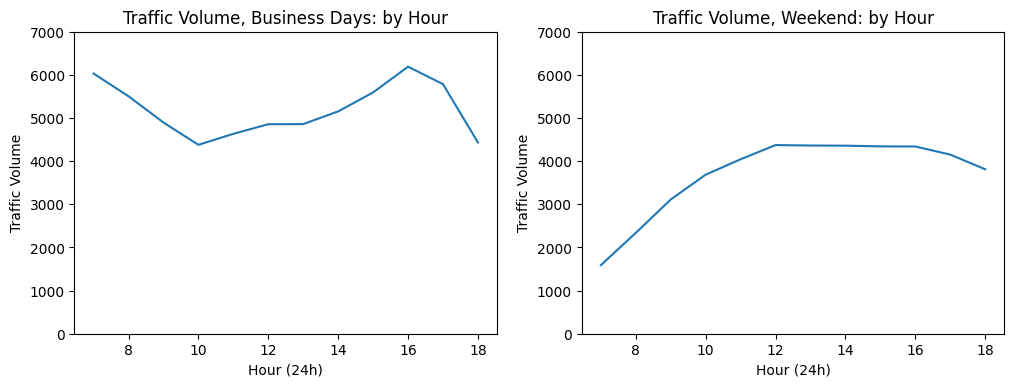

In [33]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(by_hour_business['traffic_volume'])
plt.title('Traffic Volume, Business Days: by Hour')
plt.xlabel('Hour (24h)')
plt.ylabel('Traffic Volume')
plt.ylim([0,7000])

plt.subplot(1, 2, 2)
plt.plot(by_hour_weekend['traffic_volume'])
plt.title('Traffic Volume, Weekend: by Hour')
plt.xlabel('Hour (24h)')
plt.ylabel('Traffic Volume')
plt.ylim([0,7000])

plt.show()

**Analysis**: Based on both charts above, we can conclude that 
* Traffic peaks at business days on 07:00 and 16:00 with average volume of 6030 and 6189 respectively. This checks out with most work hours on the office. 
* Traffic peaks at weekend on 12:00 - 16:00. This may be because of people going home or having a vacation to St. Paul.

## (2) Weather

Now we've done the time out of the way, we can move onto the other columns left, which is the weather and temperature. We're starting by finding correlations on `day['traffic_volume']` to each columns, including `rain_1h`, `snow_1h`, and `clouds_all`

In [38]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

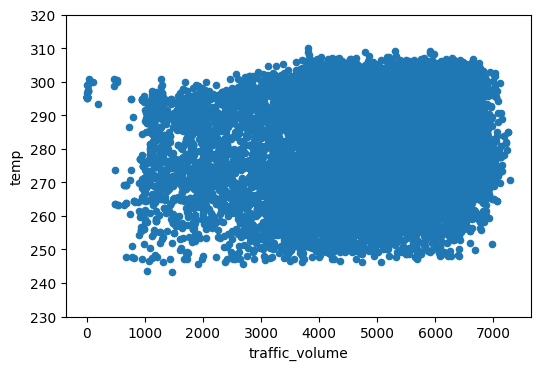

In [41]:
# Strongest weather correlation: temp
day.plot.scatter('traffic_volume', 'temp')
plt.ylim([230,320])
plt.show()

Looks like the temperature `temp` doesn't have a good correlation from the picture. It doesn't show any sign of (+) or (-). So it's not an indication of heavy traffic.

What about the weather in `weather_main`?

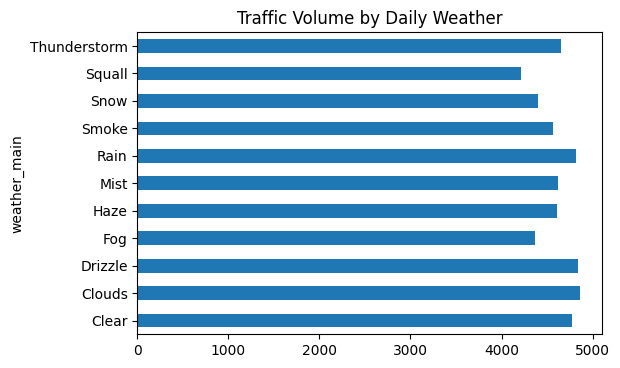

In [45]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_description = day.groupby('weather_description').mean()

by_weather_main['traffic_volume'].plot.barh()
plt.title('Traffic Volume by Daily Weather')
plt.show()

Based on the horizontal bar above, we can see there is no weather that impacts to traffic volume exceeding 5,000 cars. Even the harshest ones like Thunderstorm and Rain doesn't impact to the traffic. With this we can conclude that `weather` is also not a heavy traffic indicator.

Based on the data analysis above, we can conclude that:
* Traffic volume of I-94 US is heavy on daytime and light on nighttime
* Traffic volume of I-94 at daytime peaks on business days (Mon-Fri) on month 2-6 (Feb-Jun) and  10-12 (Oct-Dec).
* The daytime traffic peaks occur at 07:00 and 16:00.
* Temperature and weather is not